# Synthetic outbreak simulation

This notebook evaluates the sensitivity of our econometrically-derived estimates of the impact of policy on infection growth rates given a variety of epidemiological and demographic parameters. Using a Monte Carlo approach, it simulates an outbreak progression using SIR and/or SEIR dynamics, allowing for noise in the $\beta$, $\gamma$, and $\sigma$ parameters, along with measurement noise in the daily growth rate. It allows $\beta$ to be affected by policy interventions. For each MC draw, after simulating the outbreak, it then uses our regression estimation framework (Eq. 7 from the paper) to obtain estimates for the impact of those policies. We then compare the distribution of estimates with the true values, under various assumptions for the values of $\gamma$ and $\sigma$, different population sizes, and different state variables used on the left-hand-side of the regression.

One main difference in this simulation is that we are running *time series* regressions, rather than *panel* regressions (in which we observe multiple time series, one for each subnational administrative unit). Thus, noise will have a larger impact on our policy effect estimates in these simulations than they would if we were to have a panel dataset for each simulation.

In [10]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import xarray as xr
from collections import OrderedDict
from codes import utils as cutil
from codes.models import epi

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(context="notebook", style="ticks")

out_home = cutil.RESULTS / "other" / "sims"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Defining the search space

We want to simulate over a range of population and disease parameters that are relevant to the outbreaks used in our main analysis. To do so, we first examine the values seen for these parameters across the administrative units of analysis.

In [11]:
dfs = []
for i in cutil.ISOS:
    df = pd.read_csv(cutil.MODELS / "reg_data" / f"{i}_reg_data.csv")
    name_cols = [c for c in df.columns if c.endswith("_name") and not c.startswith("adm0") and c != "adm1_adm2_name"]
    df["admX_name"] = df[name_cols].agg('_'.join, axis=1)
    df = df.drop(columns=name_cols).set_index(["adm0_name","admX_name"], drop=True)
    dfs.append(df)
reg_df = pd.concat(dfs)
reg_df["date"] = pd.to_datetime(reg_df.date)
reg_df = reg_df[reg_df.cum_confirmed_cases.notnull()]

### Population

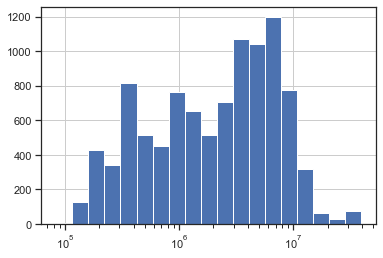

In [12]:
logbins = np.logspace(np.log10(reg_df.population).min(),np.log10(reg_df.population).max(),20)
reg_df.population.hist(bins=logbins)
plt.xscale("log")

A range between 10^5 and 10^8 seems to capture most of the admin units we study.

In [13]:
underreporting_df = pd.read_csv(cutil.DATA_INTERIM / "multi_country" / "under_reporting.csv", usecols=["country", "underreporting_estimate"], index_col="country")
underreporting_df = underreporting_df.rename(
    index={
        "China": "CHN",
        "France": "FRA",
        "Iran": "IRN",
        "Italy": "ITA",
        "South Korea": "KOR",
        "United States of America": "USA"
    }
)

reg_df = reg_df.join(underreporting_df, on="adm0_name")
cases = reg_df.cum_confirmed_cases / reg_df.underreporting_estimate
S = 1 - (cases / reg_df.population)
S_min = S.groupby(level=[0,1]).min()
frac_above_95 = (S_min>.95).sum() / S_min.shape[0]

print(f"Minimum susceptible fraction observed: {S.min():.3f} {S.idxmin()}, {int(cases.loc[S.idxmin()].max()):d} out of {reg_df.loc[S.idxmin(),'population'].max():d}")
print(f"p05: {S.groupby(level=[0,1]).min().quantile(.05):.3f}")
print(f"{frac_above_95:.2%} of admin units above S=0.95 at end of sample")

Minimum susceptible fraction observed: 0.780 ('ITA', 'Lombardia_Cremona'), 78888 out of 358955
p05: 0.929
85.97% of admin units above S=0.95 at end of sample


/home/bolliger/miniconda3/envs/gpl-covid/lib/python3.7/site-packages/ipykernel_launcher.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/bolliger/miniconda3/envs/gpl-covid/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


After correcting for underreporting, 95% of the admin units analyzed still finish with over 93% susceptible, indicating that the assumption of asymptotically exponential growth is reasonable. For a few admin units, the percentage of the population remaining susceptible drops below 80% at the end of the observational period used in regression.

Below, we look at a few examples of high pop/high S and low pop/low S locations

In [14]:
S_sorted = S.groupby(level=[0,1]).min().sort_values()
S_sorted = S_sorted[S_sorted.notnull()]
S_sorted.name="S"

In [15]:
Spop = pd.DataFrame(S_sorted).join(reg_df.population.drop_duplicates(), how="left")
Spop[Spop.S>.99].sort_values("population")

S  population
adm0_name admX_name                                                        
ITA       Molise_Isernia                               0.991221     84379.0
          Sardegna_Oristano                            0.996830    157707.0
          Calabria_Vibo Valentia                       0.993059    160073.0
          Sardegna_Nuoro                               0.994228    208550.0
          Sicilia_Caltanissetta                        0.992662    262458.0
...                                                         ...         ...
USA       Florida                                      0.994399  20278447.0
          Texas                                        0.997695  27419612.0
CHN       Chongqing_Chongqing                          0.999945  32756100.0
USA       California                                   0.996508  38982847.0
CHN       Sichuan_Garzê Tibetan Autonomous Prefecture  0.999917         NaN

[230 rows x 2 columns]

In [16]:
Spop[Spop.S<.8].sort_values("population")

,,S,population
adm0_name,admX_name,,
ITA,Lombardia_Cremona,0.780226,358955.0


### Length of time series

(29.074626865671643, <matplotlib.axes._subplots.AxesSubplot at 0x7f50db355510>)

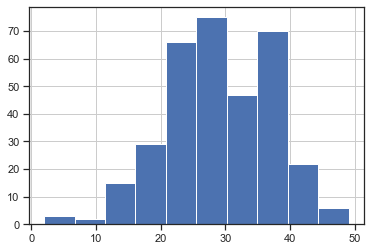

In [17]:
duration = (reg_df.groupby(level=[0,1]).date.max() - reg_df.groupby(level=[0,1]).date.min()).dt.days
duration.mean(), duration.hist()

45 days seems like a decent duration to pick for our simulations (you can play with others by turning the relevant knobs below). Note that these timeseries begin at 10 cumulative confirmed cases, while our simulation takes ~7-10 days to get to that point from the initial confirmed case.

### Duration of no-policy regime

Text(0.5, 1.0, 'Days to first policy from beginning of regression')

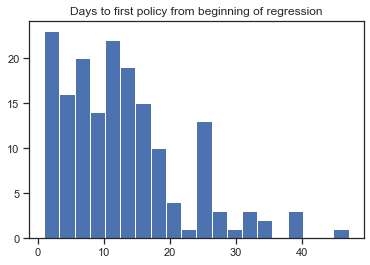

In [18]:
policy_vars = reg_df.set_index("date", append=True).iloc[:,7:]
policy_vars = policy_vars[[c for c in policy_vars.columns if "testing_regime" not in c]].select_dtypes("number")

days_to_first_pol = (policy_vars>0).groupby(
    level=[0,1]
).apply(
    lambda x: x.reset_index(drop=True).idxmax(axis=0, skipna=False)
).groupby(level=0).max()
d = days_to_first_pol.values.flatten()
plt.hist(d[d>0], bins=20)
plt.title('Days to first policy from beginning of regression')

Based on this analysis, we are going to set our simulations to have the first policy start sometime 10-15 days into the simulation. This corresponds to 10-15 days after the first exposure, even though we don't start the regression until there are 10 cumulative cases, which often takes 7-10 days given the parameters we are evaluating. This means that many policies will be starting immediately after the synthetic regression dataset begins. This provides robustness in estimating no-policy growth rates with limited no-policy observations. The figure above shows the distribution of within-country maxima for the value "days from the start of the regression to the first policy".

### Duration after last policy

Text(0.5, 1.0, 'Distribution of Max days after last policy for all admin units in a country')

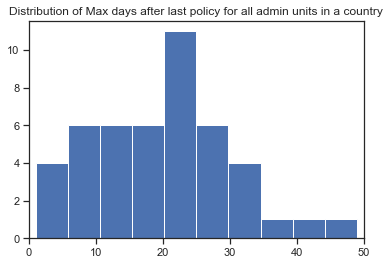

In [19]:
days_after_last_pol = (policy_vars.sort_index(ascending=False)>0).groupby(
    level=[0,1]
).apply(
    lambda x: x.reset_index(drop=True).idxmax(axis=0, skipna=False)
).groupby(level=0).max()
d = days_after_last_pol.values.flatten()
plt.hist(d[d>0])
plt.xlim(0,50)
plt.title('Distribution of Max days after last policy for all admin units in a country')

### Reasonable noise settings

We can look at the RMSE of daily growth rates from our model predictions and use that to find a rough value that can be used to parameterize noise in the transmission rate $\beta$ in the simulations.

In [20]:
resid_file = cutil.RESULTS / "source_data" / "ExtendedDataFigure10_e.csv"
rmses = pd.read_csv(resid_file, usecols=[1]).e
rmse = np.sqrt(rmses**2).mean()
rmse

0.0664951348334208

## Settings

Based on the rough diagnostics of our regression datasets depicted above, we have chosen some reasonable search parameters for this simulation exercise. You may alter them in the below cell to try out new parameter groupings. See the docstring for `codes.epi.simulate_and_regress` for the definition of each setting.

In [27]:
# sim settings
n_days = 45
tsteps_per_day = 24
n_samples = 1000
pops = [1e5, 1e6, 1e7, 1e8]

# epi settings
E0 = 1
I0 = 0
R0 = 0
gamma_to_test = [0.05, 0.2, 0.33]
sigma_to_test = [0.2, 0.33, 0.5]

# regression settings
min_cases = 10
LHS_vars = ["I", "EI", "IR", "EIR"]
reg_lag_days = [0]
random_end = True

# policy settings
no_policy_growth_rate = 0.4

# policy effects settings
p_effects = [-0.05, -0.1, -0.2]
p_lags = [
    [],
    [],
    [],
]
p_start_interval = [10, 25]
ordered_policies = False
random_end = True

# stochasticity settings
measurement_noise_on = "normal"
measurement_noise_sd = .05 # only used if noise_on="normal"

beta_noise_on = "exponential"
beta_noise_sd = 0

gamma_noise_on = "normal"
gamma_noise_sd = .01

sigma_noise_on = "normal"
sigma_noise_sd = .03

In [28]:
# choose where to save results
strs = []
sds = [measurement_noise_sd, beta_noise_sd, gamma_noise_sd, sigma_noise_sd]
for nx,n in enumerate([measurement_noise_on, beta_noise_on, gamma_noise_on, sigma_noise_on]):
    if n=="exponential":
        strs.append("Exp")
    elif n=="inv_exponential":
        strs.append("invExp")
    elif n=="normal":
        strs.append(sds[nx])
    elif not n:
        strs.append(0)
reg_dir = out_home / "measNoise_{}_betaNoise_{}_gammaNoise_{}_sigmaNoise_{}".format(*strs)
reg_dir.mkdir(parents=True, exist_ok=True)

## Run simulations

In [29]:
reg_res_ds = {
    "SIR": [],
    "SEIR": []
}
for m in ["SIR", "SEIR"]:
    print(m)
    if m=="SIR":
        this_I0 = E0
    elif m=="SEIR":
        this_I0 = I0
    for p in pops:
        print(p)
        reg_res_ds[m].append(
            epi.simulate_and_regress(
                p,
                no_policy_growth_rate,
                p_effects,
                p_lags,
                p_start_interval,
                n_days,
                tsteps_per_day,
                n_samples,
                LHS_vars,
                reg_lag_days,
                gamma_to_test,
                min_cases,
                sigma_to_test=sigma_to_test,
                measurement_noise_on=measurement_noise_on,
                measurement_noise_sd=measurement_noise_sd,
                beta_noise_on=beta_noise_on,
                beta_noise_sd=beta_noise_sd,
                sigma_noise_sd=sigma_noise_sd,
                sigma_noise_on=sigma_noise_on,
                gamma_noise_on=gamma_noise_on,
                gamma_noise_sd=gamma_noise_sd,
                E0=E0,
                I0=this_I0,
                R0=R0,
                save_dir=reg_dir / m / "regression",
                kind=m,
                ordered_policies=ordered_policies,
                random_end=random_end
            )
        )

SIR
100000.0


/home/bolliger/git_repos/gpl-covid/codes/models/epi.py:362: UserWarning: Parameter gamma has 165519/3243000 values <0 (5.10%). These are non-physical params. If they are dropped in the simulation, this will change the mean. Fraction of negative values:           gamma_stoch
gamma                
0.002086     0.153100
0.008368     0.000017
0.013845     0.000000
  f"Parameter {param} has {n_bad}/{n_tot} values <0 ({n_bad/n_tot:.2%}). "


1000000.0


/home/bolliger/git_repos/gpl-covid/codes/models/epi.py:362: UserWarning: Parameter gamma has 165519/3243000 values <0 (5.10%). These are non-physical params. If they are dropped in the simulation, this will change the mean. Fraction of negative values:           gamma_stoch
gamma                
0.002086     0.153100
0.008368     0.000017
0.013845     0.000000
  f"Parameter {param} has {n_bad}/{n_tot} values <0 ({n_bad/n_tot:.2%}). "


10000000.0


/home/bolliger/git_repos/gpl-covid/codes/models/epi.py:362: UserWarning: Parameter gamma has 165519/3243000 values <0 (5.10%). These are non-physical params. If they are dropped in the simulation, this will change the mean. Fraction of negative values:           gamma_stoch
gamma                
0.002086     0.153100
0.008368     0.000017
0.013845     0.000000
  f"Parameter {param} has {n_bad}/{n_tot} values <0 ({n_bad/n_tot:.2%}). "


100000000.0


/home/bolliger/git_repos/gpl-covid/codes/models/epi.py:362: UserWarning: Parameter gamma has 165519/3243000 values <0 (5.10%). These are non-physical params. If they are dropped in the simulation, this will change the mean. Fraction of negative values:           gamma_stoch
gamma                
0.002086     0.153100
0.008368     0.000017
0.013845     0.000000
  f"Parameter {param} has {n_bad}/{n_tot} values <0 ({n_bad/n_tot:.2%}). "


SEIR
100000.0


/home/bolliger/git_repos/gpl-covid/codes/models/epi.py:362: UserWarning: Parameter gamma has 165647/3243000 values <0 (5.11%). These are non-physical params. If they are dropped in the simulation, this will change the mean. Fraction of negative values:           gamma_stoch
gamma                
0.002086     0.153213
0.008368     0.000022
0.013845     0.000000
  f"Parameter {param} has {n_bad}/{n_tot} values <0 ({n_bad/n_tot:.2%}). "
/home/bolliger/git_repos/gpl-covid/codes/models/epi.py:362: UserWarning: Parameter sigma has 106123/3243000 values <0 (3.27%). These are non-physical params. If they are dropped in the simulation, this will change the mean. Fraction of negative values:           sigma_stoch
sigma                
0.008368     0.086056
0.013845     0.011858
0.021052     0.000258
  f"Parameter {param} has {n_bad}/{n_tot} values <0 ({n_bad/n_tot:.2%}). "
/home/bolliger/miniconda3/envs/gpl-covid/lib/python3.7/site-packages/xarray/core/computation.py:604: RuntimeWarning: invalid

1000000.0


/home/bolliger/git_repos/gpl-covid/codes/models/epi.py:362: UserWarning: Parameter gamma has 165647/3243000 values <0 (5.11%). These are non-physical params. If they are dropped in the simulation, this will change the mean. Fraction of negative values:           gamma_stoch
gamma                
0.002086     0.153213
0.008368     0.000022
0.013845     0.000000
  f"Parameter {param} has {n_bad}/{n_tot} values <0 ({n_bad/n_tot:.2%}). "
/home/bolliger/git_repos/gpl-covid/codes/models/epi.py:362: UserWarning: Parameter sigma has 106123/3243000 values <0 (3.27%). These are non-physical params. If they are dropped in the simulation, this will change the mean. Fraction of negative values:           sigma_stoch
sigma                
0.008368     0.086056
0.013845     0.011858
0.021052     0.000258
  f"Parameter {param} has {n_bad}/{n_tot} values <0 ({n_bad/n_tot:.2%}). "
/home/bolliger/miniconda3/envs/gpl-covid/lib/python3.7/site-packages/xarray/core/computation.py:604: RuntimeWarning: invalid

10000000.0


/home/bolliger/git_repos/gpl-covid/codes/models/epi.py:362: UserWarning: Parameter gamma has 165647/3243000 values <0 (5.11%). These are non-physical params. If they are dropped in the simulation, this will change the mean. Fraction of negative values:           gamma_stoch
gamma                
0.002086     0.153213
0.008368     0.000022
0.013845     0.000000
  f"Parameter {param} has {n_bad}/{n_tot} values <0 ({n_bad/n_tot:.2%}). "
/home/bolliger/git_repos/gpl-covid/codes/models/epi.py:362: UserWarning: Parameter sigma has 106123/3243000 values <0 (3.27%). These are non-physical params. If they are dropped in the simulation, this will change the mean. Fraction of negative values:           sigma_stoch
sigma                
0.008368     0.086056
0.013845     0.011858
0.021052     0.000258
  f"Parameter {param} has {n_bad}/{n_tot} values <0 ({n_bad/n_tot:.2%}). "
/home/bolliger/miniconda3/envs/gpl-covid/lib/python3.7/site-packages/xarray/core/computation.py:604: RuntimeWarning: invalid

100000000.0


/home/bolliger/git_repos/gpl-covid/codes/models/epi.py:362: UserWarning: Parameter gamma has 165647/3243000 values <0 (5.11%). These are non-physical params. If they are dropped in the simulation, this will change the mean. Fraction of negative values:           gamma_stoch
gamma                
0.002086     0.153213
0.008368     0.000022
0.013845     0.000000
  f"Parameter {param} has {n_bad}/{n_tot} values <0 ({n_bad/n_tot:.2%}). "
/home/bolliger/git_repos/gpl-covid/codes/models/epi.py:362: UserWarning: Parameter sigma has 106123/3243000 values <0 (3.27%). These are non-physical params. If they are dropped in the simulation, this will change the mean. Fraction of negative values:           sigma_stoch
sigma                
0.008368     0.086056
0.013845     0.011858
0.021052     0.000258
  f"Parameter {param} has {n_bad}/{n_tot} values <0 ({n_bad/n_tot:.2%}). "
/home/bolliger/miniconda3/envs/gpl-covid/lib/python3.7/site-packages/xarray/core/computation.py:604: RuntimeWarning: invalid